## ML solution to the IVP of pendulum

#### Required packages

See the ODE_intro notebook for the packages.

### System 1: Simple pendulum

The simple pendulum setting is described in:

 * [Wikipedia](https://en.wikipedia.org/wiki/Pendulum_(mechanics))
 * [Blog](https://akhatib.com/simple-state-space-model-of-a-pendulum/)

#### Define a number of useful functions

Pendulum ODE function

In [3]:
def f(t_, x_):
    g = -9.81
    l = 2.0
    dotx = np.empty(x_.shape)
    dotx[0] = x_[1] # angular velocity
    dotx[1] = -g/l*np.sin(x_[0]) # angular acceleration
    return dotx

Plot function 

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

def pendulum_plot(t_,y_):
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    plt.plot(t_, y_[0,:]*180/np.pi)
    plt.plot(t_, y_[0,:]*180/np.pi,'k.')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\theta$ [deg]')
    plt.subplot(122)
    plt.plot(t_, y_[1,:])
    plt.plot(t_, y_[1,:],'k.')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\dot\theta$ [rad/s]')
    #plt.tight_layout
    #plt.savefig('ode_pendulum_euler_100pts.png')
    plt.show()

def pendulum_comparison_plot(t_gt_,y_gt_, t_, y_):
    plt.figure(figsize = (12, 4))
    plt.subplot(121)
    plt.plot(t_gt_, y_gt_[0,:]*180/np.pi,'k-')
    plt.plot(t_, y_[0,:]*180/np.pi,'r--')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\theta$ [deg]')
    plt.subplot(122)
    plt.plot(t_gt_, y_gt_[1,:],'k-')
    plt.plot(t_, y_[1,:],'r--')
    plt.xlabel('time t [s]')
    plt.ylabel(r'$\dot\theta$ [rad/s]')
    plt.legend(['GT', 'Pred'])
    #plt.tight_layout
    #plt.savefig('ode_pendulum_euler_100pts.png')
    plt.show()

Trajectory generation - make sure the angle is pointing downwards so that sinusoida nonlinearities do not occur

In [6]:
def gen_trajectory(t_0_, t_n_, Delta_t_):

    # starting point is random (point downwards, though) and velocity zero
    y0 = [np.random.uniform(np.pi-np.pi/2, np.pi+np.pi/2), 0]

    t_eval = np.arange(t_0_, t_n_, Delta_t_)

    sol = solve_ivp(f, [t_0_, t_n_], y0, method = 'RK45', t_eval=t_eval)
    return sol

Trajectories of variable lenght to simulate the real world case better

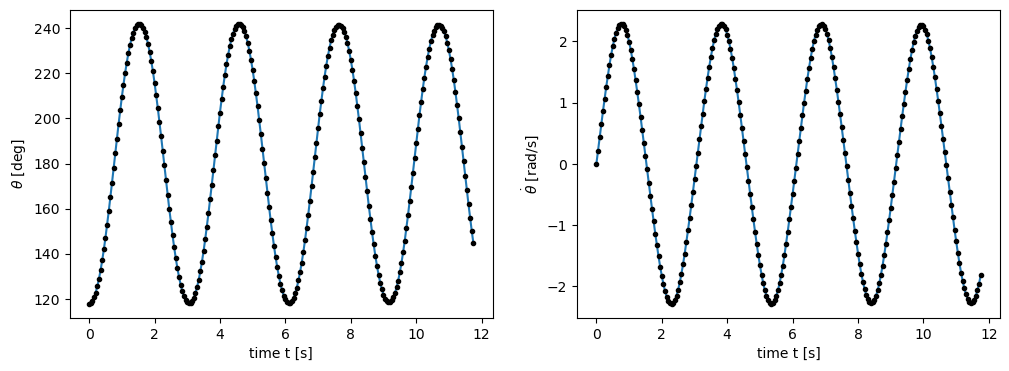

In [9]:
sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
pendulum_plot(sol.t, sol.y)

#### Finally, generate training and test data sets

In [10]:
N_tr = 13
N_te = 11

Y_tr = []
T_tr = []
Y_te = []
T_te = []

tot_samples_tr = 0
for t in range(N_tr):
    sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
    tot_samples_tr += sol.y.shape[1]
    Y_tr.append(sol.y)
    T_tr.append(sol.t)

tot_samples_te = 0
for t in range(N_te):
    sol = gen_trajectory(0,np.random.uniform(10,15), 0.05)
    tot_samples_te += sol.y.shape[1]
    Y_te.append(sol.y)
    T_te.append(sol.t)

print(f'Generated the total of {tot_samples_tr} training and {tot_samples_te} test samples')

Generated the total of 3107 training and 2806 test samples


### Neural regression

Basic neural network structure (two-layer MLP)

In [12]:
import torch

class BasicMLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super().__init__()

        self.dense1 = torch.nn.Linear(input_dim, hidden_size)
        self.dense2 = torch.nn.Linear(hidden_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_dim)

    def forward(self, x):

        x = self.dense1(x)
        x = torch.nn.functional.sigmoid(x)
        x = self.dense2(x)
        x = torch.nn.functional.sigmoid(x)
        y_pred = self.output(x)

        return y_pred

#### MLP

Construct MLP

In [25]:
# Input [t,theta_0, dottheta_0] Output: [theta, dottheta]
model_mlp = BasicMLP(3,16,2)

print(model_mlp)
print(f'The model has {sum(p.numel() for p in model_mlp.parameters())} parameters ({sum(p.numel() for p in model_mlp.parameters() if p.requires_grad)} trainable)')
print(f'Manual counting: {(3+1)*16+(16+1)*(16)+(16+1)*2}')

BasicMLP(
  (dense1): Linear(in_features=3, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
The model has 370 parameters (370 trainable)
Manual counting: 370


Training loop

In [28]:
import torch.optim.lr_scheduler as lr_scheduler

num_of_epochs = 8000
loss_mse = torch.nn.MSELoss()
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_mlp, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
model_mlp.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       
        
        y0 = y[0,:]
        y0_vec = y0.repeat(t.shape[0],1)
        X = torch.cat((t,y0_vec),1)
        optimizer_mlp.zero_grad()
        y_pred = model_mlp(X)
        loss = loss_mse(y_pred,y)
        loss.backward()
        optimizer_mlp.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_mlp.param_groups[0]["lr"]})')

   Epoch 0 training loss 44.77880930900574 (lr=0.009998748448060077)
   Epoch 100 training loss 12.853876411914825 (lr=0.009873593254067572)
   Epoch 200 training loss 10.047384202480316 (lr=0.009748438060075068)
   Epoch 300 training loss 9.315845787525177 (lr=0.009623282866082564)
   Epoch 400 training loss 9.016040027141571 (lr=0.00949812767209006)
   Epoch 500 training loss 8.651450604200363 (lr=0.009372972478097555)
   Epoch 600 training loss 7.20628659427166 (lr=0.00924781728410505)
   Epoch 700 training loss 6.568191930651665 (lr=0.009122662090112546)
   Epoch 800 training loss 6.204479783773422 (lr=0.008997506896120042)
   Epoch 900 training loss 5.898653216660023 (lr=0.008872351702127537)
   Epoch 1000 training loss 5.7632332518696785 (lr=0.008747196508135033)
   Epoch 1100 training loss 5.540364660322666 (lr=0.008622041314142528)
   Epoch 1200 training loss 5.413237176835537 (lr=0.008496886120150024)
   Epoch 1300 training loss 5.295277841389179 (lr=0.00837173092615752)
   Ep

#### MLP Evaluation

Training set performance

Average MSE over 13 trajectories is 0.6779982447624207 degrees
Average MAE over 13 trajectories is 7.389548301696777 degrees
Training trajectory and prediction number 4


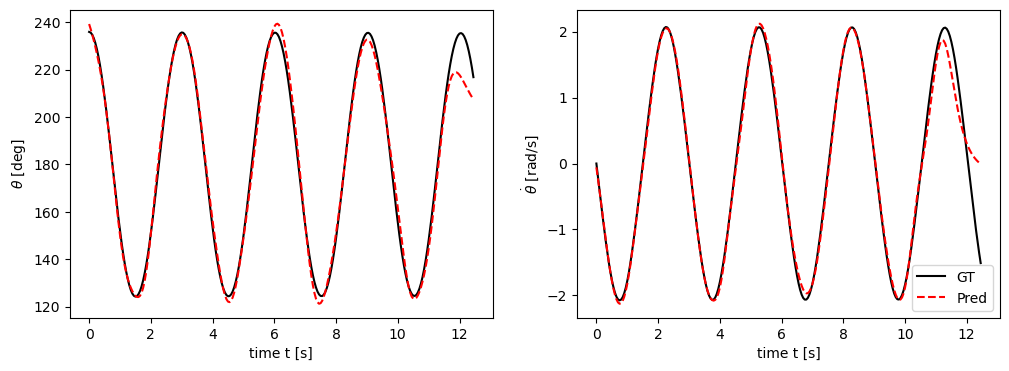

In [35]:
model_mlp.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape N,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = model_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test set performance

Average MSE over 11 trajectories is 1.4025437831878662 degrees
Average MAE over 11 trajectories is 16.546743392944336 degrees
Test trajectory and prediction number 7


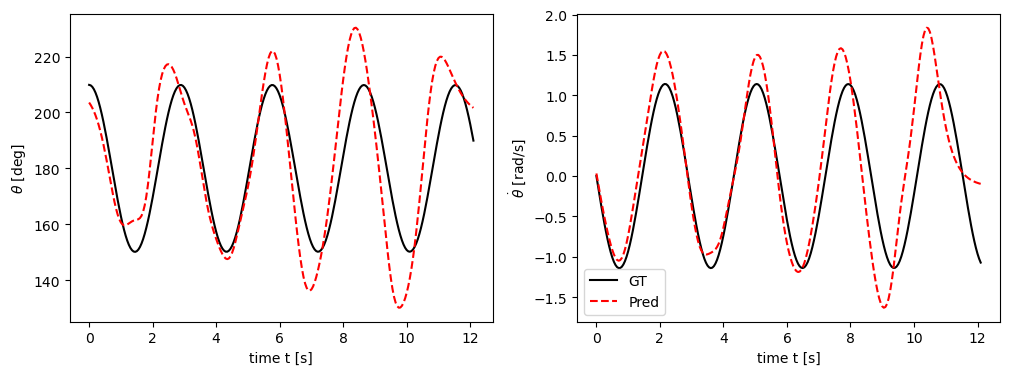

In [36]:
model_mlp.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape N,1       
        
    y0 = y[0,:]
    y0_vec = y0.repeat(t.shape[0],1)
    X = torch.cat((t,y0_vec),1)

    y_pred = model_mlp(X).detach()
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t 
avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

#### MLP-Seq

In [37]:
# Input [theta_n, dottheta_n] Output: [theta_n+1, dottheta_n+1]
model_mlpseq = BasicMLP(2,16,2)

print(model_mlpseq)
print(f'The model has {sum(p.numel() for p in model_mlpseq.parameters())} parameters ({sum(p.numel() for p in model_mlpseq.parameters() if p.requires_grad)} trainable)')

BasicMLP(
  (dense1): Linear(in_features=2, out_features=16, bias=True)
  (dense2): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
)
The model has 354 parameters (354 trainable)


Training

In [38]:
num_of_epochs = 8000
loss_mseseq = torch.nn.MSELoss()
optimizer_mlpseq = torch.optim.Adam(model_mlpseq.parameters(), lr=0.1)
scheduler = lr_scheduler.LinearLR(optimizer_mlpseq, start_factor=0.1, end_factor=0.000001, total_iters=num_of_epochs-10)
model_mlpseq.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    for y,t in zip(Y_tr,T_tr):
        y = torch.from_numpy(y).float().t() # shape N,2
        t = torch.from_numpy(t).float()
        t = t.view(len(t),1) # shape N,1       

        y_in = y[:-1,:]
        y_out = y[1:,:]
        optimizer_mlpseq.zero_grad()
        y_pred = model_mlpseq(y_in)
        loss = loss_mseseq(y_out,y_pred)
        loss.backward()
        optimizer_mlpseq.step()
        running_loss += loss.item()
    scheduler.step()
    if n % 100 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer_mlpseq.param_groups[0]["lr"]})')

   Epoch 0 training loss 50.58100390434265 (lr=0.009998748448060077)
   Epoch 100 training loss 0.010837953450391069 (lr=0.009873593254067572)
   Epoch 200 training loss 0.01034068304579705 (lr=0.009748438060075068)
   Epoch 300 training loss 0.005717206026019994 (lr=0.009623282866082564)
   Epoch 400 training loss 0.0025513899163343012 (lr=0.00949812767209006)
   Epoch 500 training loss 0.004187352744338568 (lr=0.009372972478097555)
   Epoch 600 training loss 0.001067878180037951 (lr=0.00924781728410505)
   Epoch 700 training loss 0.0011743332388505223 (lr=0.009122662090112546)
   Epoch 800 training loss 0.0008209697034544661 (lr=0.008997506896120042)
   Epoch 900 training loss 0.0007710125119047007 (lr=0.008872351702127537)
   Epoch 1000 training loss 0.0011206101639800181 (lr=0.008747196508135033)
   Epoch 1100 training loss 0.003095247651799582 (lr=0.008622041314142528)
   Epoch 1200 training loss 0.0009671207790233893 (lr=0.008496886120150024)
   Epoch 1300 training loss 0.0014656

#### MLP-Seq evaluation

Training set performance

Average MSE over 13 trajectories is 0.1389152556657791 degrees
Average MAE over 13 trajectories is 1.5246679782867432 degrees
Training trajectory and prediction number 1


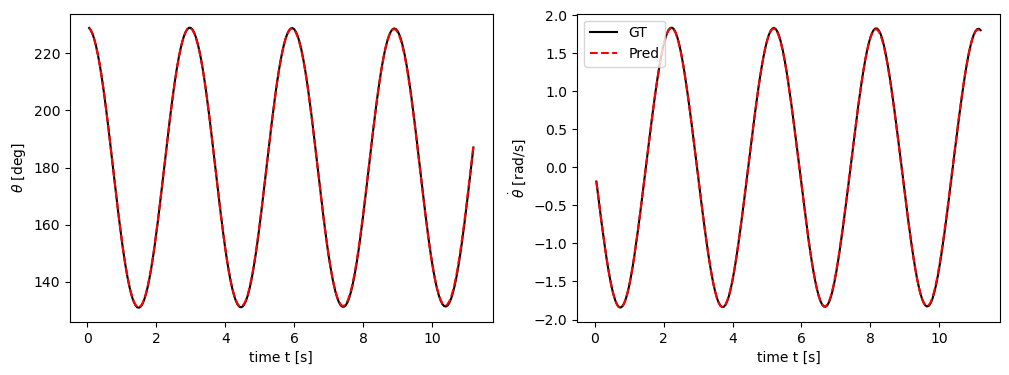

In [39]:
model_mlpseq.eval()
print_ind = np.random.randint(0,N_tr)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_tr,T_tr):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = model_mlpseq(y_in[0,:].float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = model_mlpseq(y_pred[te_ind-1,:])
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())

Test set performance

In [ ]:
model_mlpseq.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []
for y,t in zip(Y_te,T_te):
    ind += 1
    y = torch.from_numpy(y).float().t() # shape N,2
    t = torch.from_numpy(t).float()
    t = t.view(len(t),1) # shape Nhttps://pytorch.org/docs/stable/generated/torch.t.html#torch.t,1       

    y_in = y[:-1,:]
    y_out = y[1:,:]
    t_out = t[1:]
    y_pred = torch.empty(y_out.shape)
    y_pred[0,:] = model_mlpseq(y_in[0,:].float())

    for te_ind in range(1,y_out.shape[0]):
        y_pred[te_ind,:] = model_mlpseq(y_pred[te_ind-1,:])
    y_pred = y_pred.detach()
    y = y_out # First element is not counted as it is not estimated
    t = t_out
    
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(y[:,0]-y_pred[:,0],2)))/y.shape[0])
    theta_mae.append(torch.sum(abs(y[:,0]-y_pred[:,0]))/y.shape[0])
    
    if ind == print_ind:
        y_plot = y
        y_pred_plot = y_pred
        t_plot = t

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
pendulum_comparison_plot(t_plot,y_plot.t(),t_plot, y_pred_plot.t())